# Data Collection and Exploration

## Import and Connect

In [292]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from datetime import datetime
from scipy import stats
import random
%matplotlib inline

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Class and Function Definitions

**Functions**

In [4]:
def query(q_string):
    """Performs a SQL query based complete query string.
    
    argument:
    q_string: A complete SQLite query string.
    
    returns: Dataframe with results from q_string query.
    """
    
    c.execute(q_string)
    temp_df = pd.DataFrame(c.fetchall())
    temp_df.columns = [x[0] for x in c.description]
    
    return temp_df

In [5]:
def hist_small_multiples(df, plot_id = 'CategoryId', data = 'UnitPrice',
                         x_limits = None, y_limits = None, shape = (2, 4), 
                         figsize = (15, 8), bins = 30, suptitle = None,
                         x_label = None, y_label = None, 
                         plot_title_col = 'CategoryName', sharex = False,
                         sharey = False, color = 'blue'):
    """Function to create a set of subplots with specified shape, limits,
    figsize, bins, titles, and labels.
    
    arguments:
    x_limits: list of tuples indicating xlim for each plot.
        defaults to None.
    y_limits: list of tuples indicating ylim for each plot.
        defaults to None.
    
    returns: as many subplots as are inherent in the data presented."""
    
    fig, axes = plt.subplots(shape[0], shape[1], figsize = figsize,
                             sharex = sharex, sharey = sharey)
    fig.suptitle(suptitle, fontsize = 16)
    plt.subplots_adjust(hspace = .3)
    for id in sorted(df[plot_id].unique()):
        axa = (id - 1) // shape[1]
        axb = (id - 1) % shape[1]
        df[df[plot_id] == id][data].hist(ax = axes[axa][axb], 
            bins = bins, color = color)
        if plot_title_col is not None:
            axes[axa][axb].set_title(
                df.loc[df[plot_id] == id][plot_title_col].unique()[0])
        if x_label is not None:
            axes[axa][axb].set_xlabel(x_label)
        if y_label is not None:
            axes[axa][axb].set_ylabel(y_label)
        if x_limits is not None:
            if (type(x_limits)) == list:
                axes[axa][axb].set_xlim(x_limits[id - 1][0], 
                                        x_limits[id - 1][1])
            if (type(x_limits)) == tuple:
                axes[axa][axb].set_xlim(x_limits[0], x_limits[1])
        if y_limits is not None:
            for i in range(len(df[plot_id].unique())):
                if (type(y_limits)) == list:
                    axes[axa][axb].set_ylim(y_limits[id - 1][0], 
                                            y_limits[id - 1][1])
                if (type(y_limits)) == tuple:
                    axes[axa][axb].set_ylim(y_limits[0], y_limits[1])
    plt.show()

In [6]:
def welch_test(a, b, two_sided = False):
    # Calculate Welch's t-statistic for two samples.
    # a is control, b is test. I was too lazy to change them all.
    num = a.mean() - b.mean()
    denom = ((a.var(ddof = 1) / len(a)) + (np.var(b, ddof=1) / len(b))) ** .5    
    t = abs(num / denom) # capture the t-score
    
    # Calculate the effective degrees of freedom for two samples.
    num = ((a.var(ddof = 1) / len(a)) + (b.var(ddof = 1) / len(b))) ** 2
    denom = ((a.var(ddof = 1) / len(a))**2 / (len(a) - 1)) + (
            (b.var(ddof = 1) / len(b))**2 / (len(b) - 1))
    df = abs(num / denom)# Return the degrees of freedom
    
    p = 1 - stats.t.cdf(t, df)# P value    
    
    if two_sided == True:
        p = p * 2

    print('t-score: ', t, ' | Degrees of freedom: ', df)
    print('P value: ', p)
    print('-----'*16)
    
#     return p, t, df 

**Classes**

In [7]:
class Query():
    """Creates an object with methods that will submit queries and return
    dataframes constructed from those queries.
    
    methods:
    basic(table_name)
    returns all values from a given SQL table name.
    
    join(table1, table2, on)
    accepts two SQL table names and an 'ON' clause.
    returns all values from two joined tables as paired by 'on' variable.
    
    where(table1, criteria)
    accepts a SQL table name and a 'WHERE' clause.
    returns all values for a specified table based on specified condition.
    
    custom(q_string)
    accepts a complete SQL query as represented as a string.
    retursn values as specified in string query 'q_string' argument."""
    
    def basic(table_name):
        q_string = f"""SELECT * FROM {table_name}"""
        return query(q_string)
    
    def join(table1, table2, on):
        q_string = f"""SELECT * FROM {table1} JOIN {table2} on {on}"""
        return query(q_string)
    
    def where(table1, criteria):
        q_string = f"""SELECT * FROM {table1} WHERE {criteria}"""
        return query(q_string)
        
    def custom(q_string):
        return query(q_string)

In [8]:
# Probably won't wind up using this.

# class Table_Details ():
    
#     def __init__(table_name):
#         self.table_name = table_name
#         self.df = query(f"""SELECT * FROM {table_hame}""")
        
#     def query(q_string):
#         c.execute()

## Database Overview

### Table List

In [9]:
q = Query

In [10]:
tables = q.custom("""SELECT name FROM sqlite_master WHERE type ='table' AND 
             name NOT LIKE 'sqlite_%'""")

In [11]:
tables

,name
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


### Table Exploration

In [12]:
q.basic('employee').head(1)

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


In [13]:
q.basic('category').head(1)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


In [14]:
q.basic('customer').head(1)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545


In [15]:
q.basic('shipper').head(1)

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831


In [16]:
q.basic('supplier').head(1)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None


In [17]:
q.basic('"Order"').head(1)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France


In [18]:
q.basic('Product').head(1)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0


In [19]:
order_detail = q.basic('OrderDetail')

In [20]:
q.basic("Region").head(1)

,Id,RegionDescription
0,1,Eastern


In [21]:
q.basic('Territory').head(1)

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1


In [22]:
q.basic("EmployeeTerritory").head(1)

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897


## Joins

### Master DataFrame

In [23]:
master = q.custom("""SELECT * FROM OrderDetail
                       JOIN Product ON OrderDetail.ProductId = Product.Id
                       JOIN Category ON Product.CategoryId = Category.Id
                       JOIN Supplier ON Product.SupplierId = Supplier.Id
                       JOIN 'Order' AS o ON OrderDetail.OrderId = o.Id
                       JOIN Shipper ON o.ShipVia = Shipper.Id
                       JOIN Customer ON o.CustomerId = Customer.Id
                       JOIN Employee ON o.EmployeeId = Employee.Id
                       JOIN EmployeeTerritory ON Employee.Id = EmployeeTerritory.EmployeeId
                       JOIN Territory ON EmployeeTerritory.TerritoryId = Territory.Id
                       JOIN Region ON Territory.RegionId = Region.Id;""")

In [24]:
master.tail(1)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,CategoryName,Description,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,CompanyName,Phone,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath,Id,EmployeeId,TerritoryId,Id,TerritoryDescription,RegionId,Id,RegionDescription
9653,11077/77,11077,77,13.0,2,0.0,77,Original Frankfurter grüne Soße,12,2,12 boxes,13.0,32,0,15,0,2,Condiments,"Sweet and savory sauces, relishes, spreads, an...",12,Plutzer Lebensmittelgroßmärkte AG,Martin Bein,International Marketing Mgr.,Bogenallee 51,Frankfurt,Western Europe,60439,Germany,(069) 992755,None,Plutzer (on the World Wide Web)#http://www.mic...,11077,RATTC,1,2014-05-06,2014-06-03,None,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA,2,United Package,(503) 555-3199,RATTC,Rattlesnake Canyon Grocery,Paula Wilson,Assistant Sales Representative,2817 Milton Dr.,Albuquerque,North America,87110,USA,(505) 555-5939,(505) 555-3620,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp,1/19713,1,19713,19713,Neward,1,1,Eastern


In [25]:
print(master.info())
print(master.describe())
print(master.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9654 entries, 0 to 9653
Data columns (total 85 columns):
Id                      9654 non-null object
OrderId                 9654 non-null int64
ProductId               9654 non-null int64
UnitPrice               9654 non-null float64
Quantity                9654 non-null int64
Discount                9654 non-null float64
Id                      9654 non-null int64
ProductName             9654 non-null object
SupplierId              9654 non-null int64
CategoryId              9654 non-null int64
QuantityPerUnit         9654 non-null object
UnitPrice               9654 non-null float64
UnitsInStock            9654 non-null int64
UnitsOnOrder            9654 non-null int64
ReorderLevel            9654 non-null int64
Discontinued            9654 non-null int64
Id                      9654 non-null int64
CategoryName            9654 non-null object
Description             9654 non-null object
Id                      9654 non-null int64
Co

### DataFrame Sub-Joins

#### Employee + EmployeeTerritory + Territory

In [26]:
eett = q.custom("""SELECT * 
                            FROM employee AS e 
                            JOIN employeeTerritory AS et 
                            ON e.Id = et.EmployeeId 
                            JOIN Territory AS t 
                            ON t.Id = et.TerritoryId""")

In [27]:
eett.head(1)

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath,Id,EmployeeId,TerritoryId,Id,TerritoryDescription,RegionId
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp,1/06897,1,06897,06897,Wilton,1


#### Order + Order Detail + Product + Category

In [28]:
oop = q.custom("""SELECT *
            FROM 
            'Order' as o
            JOIN OrderDetail od
            ON o.Id = od.OrderId
            JOIN Product p
            ON od.ProductId = p.Id
            JOIN Category c
            ON p.CategoryId = c.Id""")

In [29]:
oop.columns = ['Id', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'Id',
       'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount', 'Id',
       'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'ProductUnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued', 'Id', 'CategoryName', 'Description']

In [30]:
oop['OrderDate'] = pd.to_datetime(oop['OrderDate'], format = '%Y-%m-%d')
oop['RequiredDate'] = pd.to_datetime(oop['RequiredDate'], format = '%Y-%m-%d')
oop['ShippedDate'] = pd.to_datetime(oop['ShippedDate'], format = '%Y-%m-%d')

In [31]:
oop.head(1)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,ProductUnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,CategoryName,Description
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0,11,Queso Cabrales,5,4,1 kg pkg.,21.0,22,30,30,0,4,Dairy Products,Cheeses


#### Product + Order + Customer + Employee

In [32]:
poce = q.custom("""SELECT *
            FROM OrderDetail od
            JOIN 'Order' o
            ON od.OrderId = o.Id
            JOIN Customer c
            ON o.CustomerId = c.Id
            JOIN Employee as e
            ON o.EmployeeId = e.Id""")

In [33]:
poce.columns = ['OrderDetailId', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount', 'OrderNumber',
       'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShippedDate',
       'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity',
       'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'DropCustId', 'CompanyName',
       'ContactName', 'ContactTitle', 'Address', 'City', 'Region',
       'PostalCode', 'Country', 'Phone', 'Fax', 'DropEmpId', 'LastName', 'FirstName',
       'Title', 'TitleOfCourtesy', 'BirthDate', 'HireDate', 'Address', 'City',
       'Region', 'PostalCode', 'Country', 'HomePhone', 'Extension', 'Photo',
       'Notes', 'ReportsTo', 'PhotoPath']

In [34]:
poce['OrderDate'] = pd.to_datetime(poce['OrderDate'], format = '%Y-%m-%d')
poce['RequiredDate'] = pd.to_datetime(poce['RequiredDate'], format = '%Y-%m-%d')
poce['ShippedDate'] = pd.to_datetime(poce['ShippedDate'], format = '%Y-%m-%d')

In [35]:
poce.head(1)

,OrderDetailId,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderNumber,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,DropCustId,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,DropEmpId,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,VINET,Vins et alcools Chevalier,Paul Henriot,Accounting Manager,59 rue de l'Abbaye,Reims,Western Europe,51100,France,26.47.15.10,26.47.15.11,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


#### Order Detail + Product + Category + Order + Employee

In [36]:
odpcoe = q.custom("""SELECT * FROM OrderDetail od
            JOIN Product p
            ON od.ProductId = p.Id
            JOIN Category c
            ON p.CategoryId = c.Id
            JOIN 'Order' o
            ON od.OrderId = o.Id
            JOIN Employee e
            ON o.EmployeeId = e.Id""")

In [37]:
odpcoe.head(1)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,CategoryName,Description,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,10248/11,10248,11,14.0,12,0.0,11,Queso Cabrales,5,4,1 kg pkg.,21.0,22,30,30,0,4,Dairy Products,Cheeses,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [704]:
odpcoe['OrderDate'] = pd.to_datetime(odpcoe['OrderDate'], format = '%Y-%m-%d')
odpcoe['RequiredDate'] = pd.to_datetime(odpcoe['RequiredDate'], format = '%Y-%m-%d')
odpcoe['ShippedDate'] = pd.to_datetime(odpcoe['ShippedDate'], format = '%Y-%m-%d')

## Drilling Down Into Data

### Employee orders by month

In [38]:
poce_month = poce.copy()

In [39]:
poce_month['YearMonth'] = poce_month.OrderDate.apply(lambda x: datetime(
    x.year, x.month, 1))

In [40]:
poce_month = poce_month[['OrderId']].groupby([poce_month.FirstName, poce_month.YearMonth]).count()

In [41]:
poce_month.head()

OrderId
FirstName YearMonth          
Andrew    2012-07-01        2
          2012-08-01        5
          2012-09-01       10
          2012-10-01        7
          2012-11-01        7

In [42]:
poce_month.unstack('FirstName').head()

OrderId                                                      
FirstName   Andrew Anne Janet Laura Margaret Michael Nancy Robert Steven
YearMonth                                                               
2012-07-01     2.0  8.0   9.0   5.0     20.0     4.0   3.0    NaN    8.0
2012-08-01     5.0  NaN   9.0  16.0     16.0     9.0  12.0    2.0    NaN
2012-09-01    10.0  NaN   5.0   7.0      7.0     8.0  11.0    5.0    2.0
2012-10-01     7.0  6.0   6.0   4.0     27.0     NaN   8.0   11.0    4.0
2012-11-01     7.0  NaN   7.0   4.0     16.0     7.0  11.0    7.0    6.0

In [43]:
employee_orders = poce[['OrderId']].groupby(poce.FirstName).count()

In [44]:
employee_orders

,OrderId
FirstName,
Andrew,237
Anne,107
Janet,313
Laura,248
Margaret,408
Michael,161
Nancy,341
Robert,150
Steven,113


### Order and Product Information

In [45]:
oop['CategoryName'].value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

#### Order / Product Pricing Issue

**Below is a problem. A quarter of the total order items have unit prices that are lower than the price on the Product table. Why is this bad? Because it reflects that the prices are *changing*, which will make it hard to get proper sampling.**

**Note that while one quarter of order items have a lower price than previously sold, _every single one_ of the items has fallen in price over time.**

In [46]:
oop[['ProductUnitPrice', 'UnitPrice']].groupby(
    oop.ProductId).agg(['min', 'max']).head(1)

ProductUnitPrice       UnitPrice      
                       min   max       min   max
ProductId                                       
1                     18.0  18.0      14.4  18.0

In [47]:
oop.count().head(1)

Id    2155
dtype: int64

In [48]:
oop[oop['UnitPrice'] < oop['ProductUnitPrice']].count().head(1)

Id    658
dtype: int64

In [49]:
oop.ProductName.value_counts().head(1)

Raclette Courdavault    54
Name: ProductName, dtype: int64

In [50]:
# price_date_exp = oop[['ProductUnitPrice', 'UnitPrice']][(oop['OrderDate'] > 
#     datetime(2011, 12, 31)) & (oop['OrderDate'] < 
#     datetime(2013, 1, 1))].groupby(oop.ProductId).agg(['min', 'max'])

In [51]:
# price_date_exp.head()

In [52]:
# price_date_exp[price_date_exp['UnitPrice']['min'] < price_date_exp['ProductUnitPrice']['min']].count()

In [53]:
oop[(oop.OrderDate > datetime(2012, 12, 31)) &
    (oop.OrderDate < datetime(2015, 1, 1))].count().head(1)

Id    1750
dtype: int64

In [55]:
# price_date_exp = oop[['ProductUnitPrice', 'UnitPrice']][(oop['OrderDate'] > 
#     datetime(2011, 12, 31)) & (oop['OrderDate'] < 
#     datetime(2013, 1, 1))]

In [56]:
# price_date_exp.head()

## Visuals

### Overview Plots

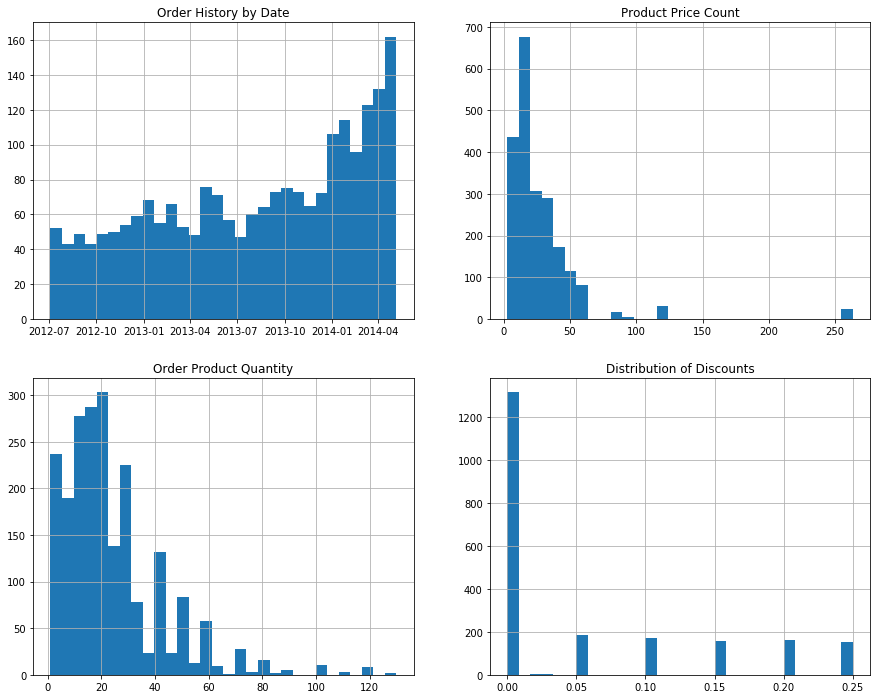

In [57]:
fig, axes = plt.subplots(2,2, figsize = (15, 12))
axes[0][0].set_title('Order History by Date')
oop.OrderDate.hist(ax = axes[0][0], bins = 30)
oop['ProductUnitPrice'].hist(ax = axes[0][1], bins = 30)
axes[0][1].set_title('Product Price Count')
oop['Quantity'].hist(ax = axes[1][0], bins = 30)
axes[1][0].set_title('Order Product Quantity')
oop['Discount'].hist(ax = axes[1][1], bins = 30)
axes[1][1].set_title('Distribution of Discounts')
plt.show();

In [58]:
categories = q.basic('category')

### Employee Sales Graphs

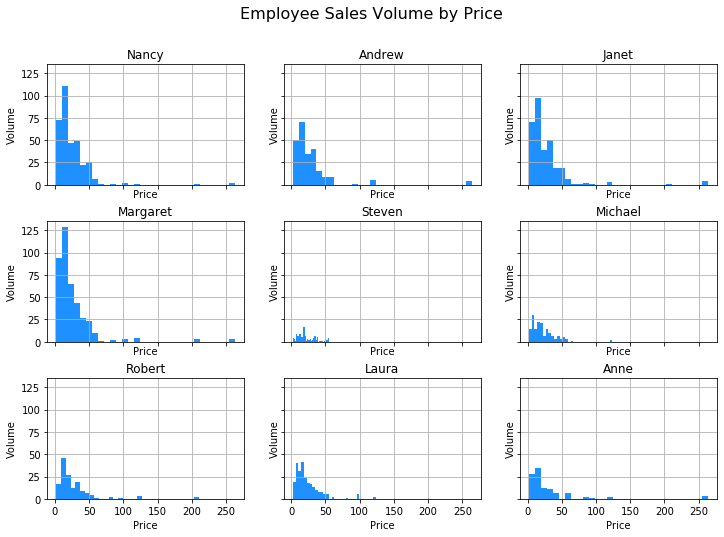

In [59]:
hist_small_multiples(plot_id = 'EmployeeId', df = poce, data = 'UnitPrice',
                     x_limits = None, y_limits = None, shape = (3, 3), 
                     figsize = (12, 8), bins = 30, 
                     suptitle = 'Employee Sales Volume by Price',
                     x_label = 'Price', y_label = 'Volume', 
                     plot_title_col = 'FirstName', sharex = True, 
                     sharey = True, color = 'dodgerblue')

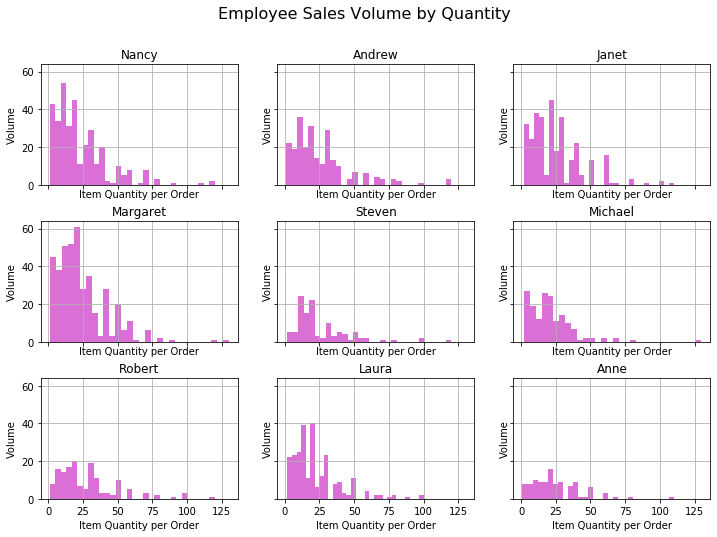

In [60]:
hist_small_multiples(plot_id = 'EmployeeId', df = poce, data = 'Quantity',
                     x_limits = None, y_limits = None, shape = (3, 3), 
                     figsize = (12, 8), bins = 30, 
                     suptitle = 'Employee Sales Volume by Quantity',
                     x_label = 'Item Quantity per Order', y_label = 'Volume', 
                     plot_title_col = 'FirstName', sharex = True, 
                     sharey = True, color = 'orchid')

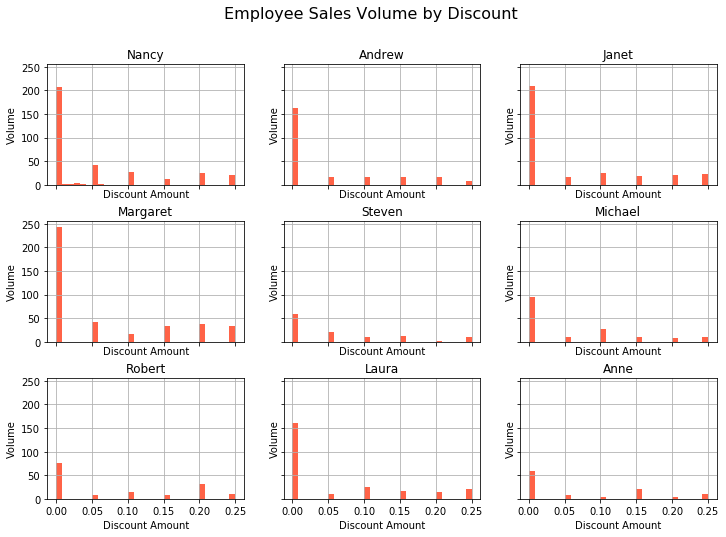

In [61]:
hist_small_multiples(plot_id = 'EmployeeId', df = poce, data = 'Discount',
                     x_limits = None, y_limits = None, shape = (3, 3), 
                     figsize = (12, 8), bins = 30, 
                     suptitle = 'Employee Sales Volume by Discount',
                     x_label = 'Discount Amount', y_label = 'Volume', 
                     plot_title_col = 'FirstName', sharex = True, 
                     sharey = True, color = 'tomato')

### Category Graphs

In [62]:
xlimits = [(0, 220), (0, 75), (0, 75), (0, 75), (0, 75), (0, 75), (0, 75), 
           (0, 75)]

ylimits = [(0, 250), (0, 80), (0, 80), (0, 80), (0, 80), (0, 80), (0, 80), 
           (0, 80)]

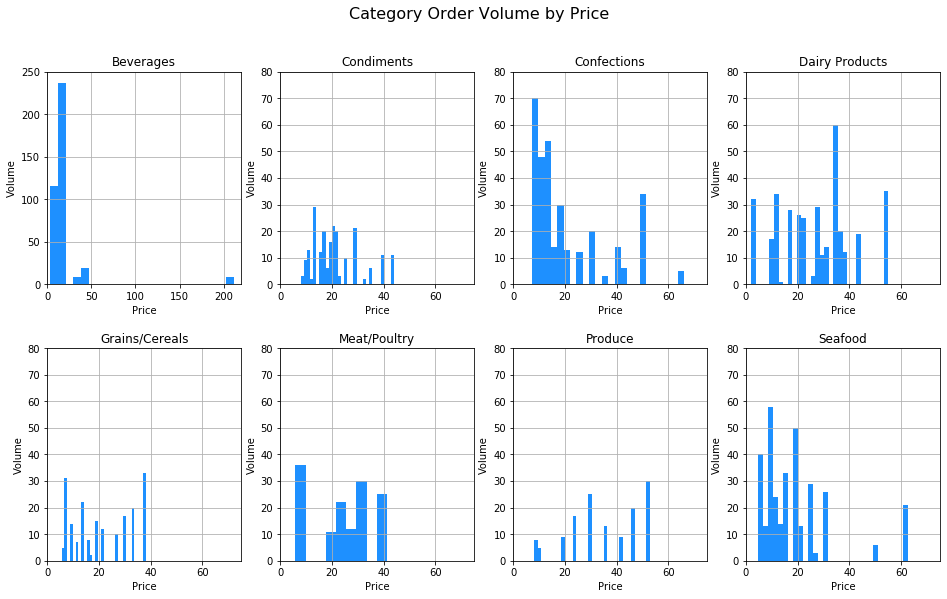

In [63]:
hist_small_multiples(plot_id = 'CategoryId', df = oop, data = 'UnitPrice',
                     x_limits = xlimits, y_limits = ylimits, shape = (2,4), 
                     figsize = (16, 9), bins = 30, 
                     suptitle = 'Category Order Volume by Price',
                     x_label = 'Price', y_label = 'Volume', 
                     plot_title_col = 'CategoryName', sharex = False, 
                     sharey = False, color = 'dodgerblue')

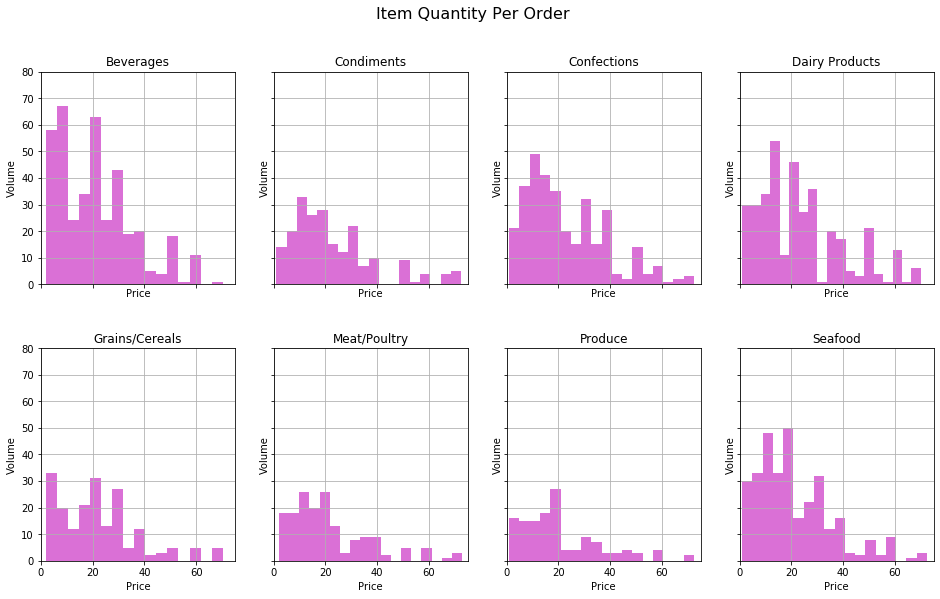

In [64]:
hist_small_multiples(plot_id = 'CategoryId', df = oop, data = 'Quantity',
                     x_limits = xlimits, y_limits = ylimits, shape = (2,4), 
                     figsize = (16, 9), bins = 30, 
                     suptitle = 'Item Quantity Per Order',
                     x_label = 'Price', y_label = 'Volume', 
                     plot_title_col = 'CategoryName', sharex = True, 
                     sharey = True, color = 'orchid')

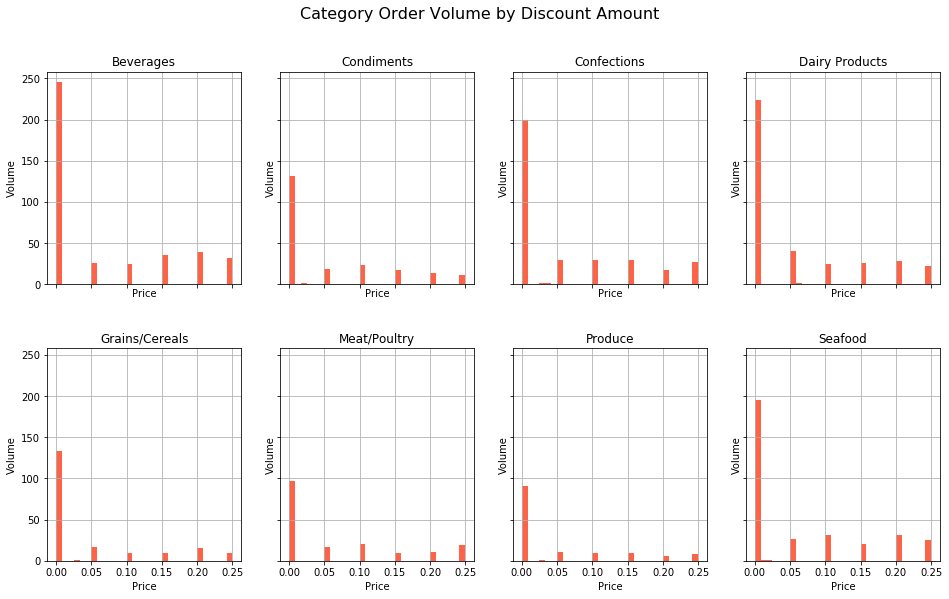

In [65]:
hist_small_multiples(plot_id = 'CategoryId', df = oop, data = 'Discount',
                     shape = (2,4), 
                     figsize = (16, 9), bins = 30, 
                     suptitle = 'Category Order Volume by Discount Amount',
                     x_label = 'Price', y_label = 'Volume', 
                     plot_title_col = 'CategoryName', sharex = True, 
                     sharey = True, color = 'tomato')

**\* Note that 'Beverages' is on a different scale due to the far greater volume and price outliers. The others are equivalent to each other.**

# Testing

## Hypothesis 1

**Null Hypothesis:**

Discount amount does not have a statistically significant effect on the quantity of a product in an order, at verious levels of discount.

**Alternative Hypothesis:**

Discount amount does have a statistically significant effect on the quantity of a product in an order, at verious levels of discount.

**Actionable Premise:**

If discount level does not create additional sales volume, it might be discontinued as lowered prices will only bring in less revenue. If discounts increase order quantity, especially at certain levels, those discount levels might be broadened to improve sales quantity.

First, clean up the dataset and check for normality.

In [66]:
# Creating a copy of the order detail / order / product DataFrame to mangle.
dis_df = oop.copy()

In [67]:
# test_start = datetime(2012, 1, 1)
# test_end = datetime(2014, 10, 31)

In [68]:
#Selecting a single year to hone in on a concretely captured data set.
# dis_df = dis_df.loc[(dis_df['OrderDate'] >= test_start) & 
#                     (dis_df['OrderDate'] <= test_end)]

In [69]:
# Removing the discounts that only appear a couple of times.
dis_df = dis_df[(dis_df['Discount'] == .05) | (dis_df['Discount'] == 0)
               | (dis_df.Discount >= .1)]

In [70]:
# Keeping only those records that have held a consistent price. 
# Reduced prices will muddy the waters between regular price and discount price.
dis_df = dis_df.loc[dis_df['UnitPrice'] == dis_df['ProductUnitPrice']]

In [71]:
# These are the discount values we're going to test.
dis_df.Discount.value_counts()

0.00    915
0.05    136
0.25    115
0.15    111
0.20    107
0.10    105
Name: Discount, dtype: int64

In [72]:
dis_df['TotalPrice'] = ((dis_df.UnitPrice - (dis_df.UnitPrice * 
                         dis_df.Discount)) * dis_df.Quantity) 

In [267]:
dis_df = dis_df[dis_df.UnitPrice < 150]

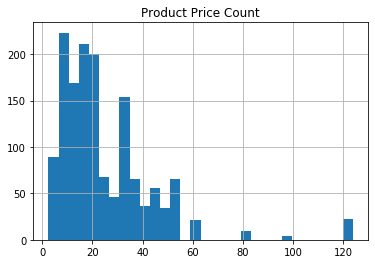

In [268]:
dis_df['ProductUnitPrice'].hist(bins = 30)
plt.title('Product Price Count')
plt.show();

In [269]:
# These are the price buckets we will use to test sales against 
# similarly priced products. Note the finely-tuned precision naming. 
# Actually, they are fairly equally spaced.
dis_df['PriceCategory'] = pd.qcut(dis_df.UnitPrice, q = 5, 
                duplicates = 'drop', labels = ['low price', 'lowish price', 
                'medium price', 'up there', 'way up there'])
dis_df['PriceCatId'] = pd.qcut(dis_df.UnitPrice, q = 5, duplicates = 'drop', 
                labels = [1, 2, 3, 4, 5])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [270]:
dis_df['PriceCategory'].value_counts()

lowish price    352
low price       312
way up there    293
up there        288
medium price    228
Name: PriceCategory, dtype: int64

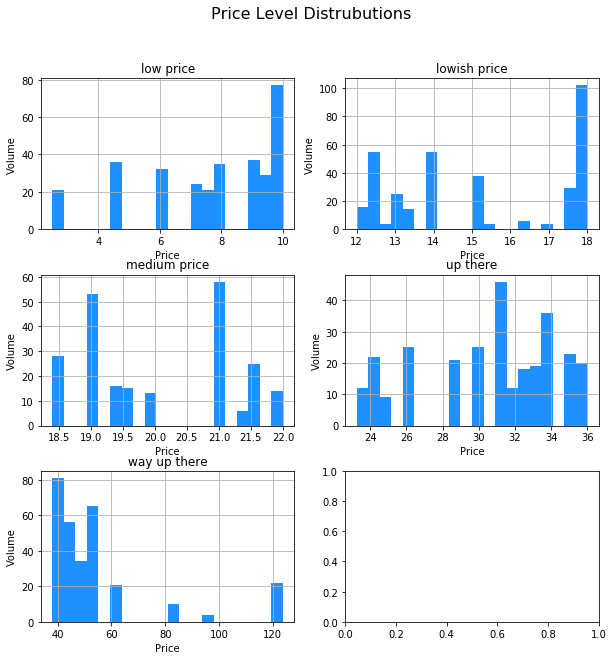

In [271]:
hist_small_multiples(dis_df, plot_id = 'PriceCatId', data = 'UnitPrice',
                         x_limits = None, y_limits = None, shape = (3, 2), 
                         figsize = (10, 10), bins = 20, suptitle = 'Price Level Distrubutions',
                         x_label = 'Price', y_label = 'Volume', 
                         plot_title_col = 'PriceCategory', sharex = False,
                         sharey = False, color = 'dodgerblue')

Creating the sample slices for testing.

In [272]:
dis_control = dis_df.loc[dis_df['Discount'] == 0]

In [273]:
dis_test = dis_df.loc[dis_df['Discount'] > 0]

We will use the same DataFrames from Hypothesis 1: dis_df, dis_control, and dis_test.

Will perform a preliminary test with all discounts just to get a first look before diving into the real work of splitting up the groups.

I'll use a Welch's t-test since we have two groups of dissimilar size to test against each other: quantities sold per order with discounts and quantities sold per order without discounts.

**Testing for Quantity: All prices against all discount levels**

In [274]:
# I used the stats.ttest_ind here with equal_var = False to perform Welch's
# t-test, since something strange happened when I tried to use my local version.
# That version worked fine for all others and had a parameter for two-sided 
# tests.
print('-----'*16)
print('Price level: All', ' | Discount: All')
print('control size: ', len(dis_control), ' | test size: ', len(dis_test))
print('Control mean: ', dis_control.Quantity.mean(), 
      ' | Test mean: ', dis_test.Quantity.mean())
print(stats.ttest_ind(dis_control.Quantity, dis_test.Quantity, 
      equal_var = False))

--------------------------------------------------------------------------------
Price level: All  | Discount: All
control size:  904  | test size:  569
Control mean:  21.788716814159294  | Test mean:  26.553602811950793
Ttest_indResult(statistic=-4.523128058310666, pvalue=6.746756040987591e-06)


I had to change the above to a scipy.stats traditional t-test because Welch's was throwing out a p-value of 7 for some reason, even though it seems to work fine everywhere else.

In [275]:
# Setting up the bins to use in price and discount variations
price_bins = ['low price', 'lowish price', 'medium price', 'up there', 
                'way up there']
discount_bins = [.05, .1, .15, .2, .25]

**Testing for Quantity: Each price level against all discounts**

In [276]:
for p_bin in price_bins:
    control = dis_control[(dis_control['PriceCategory'] == p_bin)]
    test = dis_test[(dis_test['PriceCategory'] == p_bin)]
    print('-----'*16)
    print('Price: ', p_bin, ' | Discount: All', 'control size: ', len(control),
          ' | test size: ', len(test))
    print('Control mean: ', control.Quantity.mean(), 
          ' | Test mean: ', test.Quantity.mean())
    welch_test(control.Quantity, test.Quantity, two_sided = False)

--------------------------------------------------------------------------------
Price:  low price  | Discount: All control size:  198  | test size:  114
Control mean:  21.838383838383837  | Test mean:  26.50877192982456
t-score:  1.9648606320433621  | Degrees of freedom:  230.45520650651744
P value:  0.025315925123181593
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  lowish price  | Discount: All control size:  209  | test size:  143
Control mean:  21.086124401913874  | Test mean:  27.06993006993007
t-score:  2.837706723773838  | Degrees of freedom:  231.82246621256635
P value:  0.0024732805821759962
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  medium price  | Discount: All control size:  140  | test size:  88
Control mean:  21.3  | Test mea

**Testing for Quantity: All prices against each discount level.**

In [277]:
for d_bin in discount_bins:
    control = dis_control
    test = dis_test[(dis_test['Discount'] == d_bin)]
    print('-----'*16)
    print('Price: ', 'All', ' | Discount: ', d_bin, ' | control size: ', len(control),
          ' | test size: ', len(test))
    print('Control mean: ', control.Quantity.mean(), 
          ' | Test mean: ', test.Quantity.mean())
    welch_test(control.Quantity, test.Quantity)

--------------------------------------------------------------------------------
Price:  All  | Discount:  0.05  | control size:  904  | test size:  133
Control mean:  21.788716814159294  | Test mean:  26.74436090225564
t-score:  2.528310157664793  | Degrees of freedom:  161.77466065200983
P value:  0.0062096439404395465
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  All  | Discount:  0.1  | control size:  904  | test size:  103
Control mean:  21.788716814159294  | Test mean:  24.41747572815534
t-score:  1.2432896576078558  | Degrees of freedom:  121.38769916738013
P value:  0.10807852833485732
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  All  | Discount:  0.15  | control size:  904  | test size:  111
Control mean:  21.788716814159294  | Test

**Testing for Quantity: Each price level agaist each discount level.**

In [278]:
for p_bin in price_bins:
    for d_bin in discount_bins:
        control = dis_control[(dis_control['PriceCategory'] == p_bin)]
        test = dis_test[(dis_test['PriceCategory'] == p_bin) &
                       (dis_test['Discount'] == d_bin)]
        print('-----'*16)
        print('Price: ', p_bin, ' | Discount: ', d_bin, ' | control size: ', len(control),
          ' | test size: ', len(test))
        print('Control mean: ', control.Quantity.mean(), 
          ' | Test mean: ', test.Quantity.mean())
        welch_test(control.Quantity, test.Quantity)

--------------------------------------------------------------------------------
Price:  low price  | Discount:  0.05  | control size:  198  | test size:  25
Control mean:  21.838383838383837  | Test mean:  28.88
t-score:  1.4435753085496486  | Degrees of freedom:  28.559164155113557
P value:  0.0798696118613812
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  low price  | Discount:  0.1  | control size:  198  | test size:  25
Control mean:  21.838383838383837  | Test mean:  22.56
t-score:  0.18321322609748725  | Degrees of freedom:  31.513052504936773
P value:  0.42790221523619865
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  low price  | Discount:  0.15  | control size:  198  | test size:  21
Control mean:  21.838383838383837  | Test mean:  32

Will run the Anova test now

In [279]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, dis_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F    PR(>F)
C(Discount)    8641.852708     5.0  4.672858  0.000309
Residual     542605.760326  1467.0       NaN       NaN


In [304]:
no_discount = dis_df[dis_df.Discount == 0].Quantity

In [305]:
discount = dis_df[dis_df.Discount > 0].Quantity

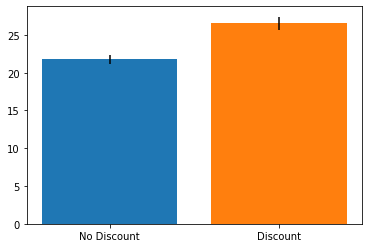

In [306]:
plt.bar(x = 'No Discount', height = no_discount.mean(), 
        yerr = stats.sem(no_discount))
plt.bar(x = 'Discount', height = discount.mean(), yerr = stats.sem(discount))
plt.show();

And the same thing again with the pairwise tukey test

In [696]:
model = pairwise_tukeyhsd(dis_df.Quantity, dis_df.Discount)

In [775]:
from statsmodels.stats.libqsturng import psturng

psturng(np.abs(model.meandiffs / model.std_pairs), len(model.groupsunique), model.df_total)

array([0.06227297, 0.74981148, 0.02829588, 0.20492957, 0.03677682,
       0.9       , 0.9       , 0.9       , 0.9       , 0.79171664,
       0.9       , 0.84282768, 0.9       , 0.9       , 0.9       ])

In [697]:
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.05,4.9556,0.0623,-0.1409,10.0522,False
0.0,0.1,2.6288,0.7498,-3.0783,8.3358,False
0.0,0.15,5.896,0.0283,0.3767,11.4153,True
0.0,0.2,4.473,0.2049,-1.1375,10.0834,False
0.0,0.25,5.6374,0.0368,0.2042,11.0705,True
0.05,0.1,-2.3269,0.9,-9.5298,4.876,False
0.05,0.15,0.9403,0.9,-6.1148,7.9955,False
0.05,0.2,-0.4827,0.9,-7.6093,6.644,False
0.05,0.25,0.6817,0.9,-6.3062,7.6697,False
0.1,0.15,3.2672,0.7917,-4.2408,10.7752,False


In [691]:
print('Price level: All', ' | Discount: All')
print(pairwise_tukeyhsd(dis_df.Quantity, dis_df.Discount))

Price level: All  | Discount: All
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05   4.9556 0.0623 -0.1409 10.0522  False
   0.0    0.1   2.6288 0.7498 -3.0783  8.3358  False
   0.0   0.15    5.896 0.0283  0.3767 11.4153   True
   0.0    0.2    4.473 0.2049 -1.1375 10.0834  False
   0.0   0.25   5.6374 0.0368  0.2042 11.0705   True
  0.05    0.1  -2.3269    0.9 -9.5298   4.876  False
  0.05   0.15   0.9403    0.9 -6.1148  7.9955  False
  0.05    0.2  -0.4827    0.9 -7.6093   6.644  False
  0.05   0.25   0.6817    0.9 -6.3062  7.6697  False
   0.1   0.15   3.2672 0.7917 -4.2408 10.7752  False
   0.1    0.2   1.8442    0.9  -5.731  9.4195  False
   0.1   0.25   3.0086 0.8428 -4.4363 10.4535  False
  0.15    0.2   -1.423    0.9 -8.8579  6.0119  False
  0.15   0.25  -0.2586    0.9 -7.5606  7.0434  False
   0.2   0.25   1.1644    0.9 -6.2067  8.5355  False
------------

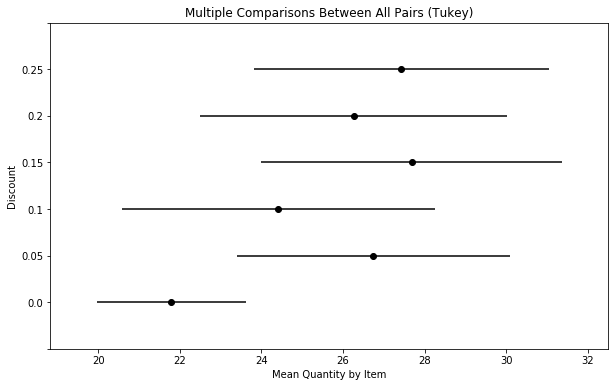

In [778]:
model.plot_simultaneous(ylabel = 'Discount', xlabel = 'Mean Quantity by Item');

**Result:**

**Null hypothesis rejected overall, and individually for .05, .15, and .25 (not .10 or .20). Althernative hypothesis accpted that quantity sold is higher for discounted items.**

.20 is very close to being able to reject the null hypothesis, and in light of the fact that the other discounts do reject the null hypothesis, a case could be made that the .20 discount is most likely legitimate. As for .10, the sample size for that one might be too small to say anything with confidence.

The broken-out discount vs broken-out price analysis seems to have too few records to reject the null hypothesis, even with the Welch's t-test applied. 

In addition, discounts were effective against all price levels from low to high.

## Hypothesis 2

**Null Hypothesis:**

Discount amount does not have a statistically significant effect on the total dollar amount of product sold in an order after accounting for discount, at various discount levels.

**Alternative Hypothesis:**

Discount amount does have a statistically significant effect on the total dollar amount of product sold in an order after accounting for discount, at various discount levels.

**Actionable Premise:**
    
Discount amounts can have an impact on the overall revenue coming in from product sales, as a balance between lower price and increased volume. The result of this can determine where and by how much discount amounts might be applied.

Will perform a preliminary test with all discounts just to get a first look before diving into the real work of splitting up the groups.

I'll use a Welch's t-test since we have two groups of dissimilar size to test against each other: quantities sold per order with discounts and quantities sold per order without discounts.

**Testing for Quantity: All prices against all discount levels**

In [86]:
# I used the stats.ttest_ind here with equal_var = False to perform Welch's
# t-test, since something strange happened when I tried to use my local version.
# That version worked fine for all others and had a parameter for two-sided 
# tests.
print('-----'*16)
print('Price level: All', ' | Discount: All')
print('control size: ', len(dis_control), ' | test size: ', len(dis_test))
print('Control mean: ', dis_control.TotalPrice.mean(), 
      ' | Test mean: ', dis_test.TotalPrice.mean())
stats.ttest_ind(dis_control.TotalPrice, dis_test.TotalPrice, equal_var = False)

--------------------------------------------------------------------------------
Price level: All  | Discount: All
control size:  915  | test size:  574
Control mean:  608.589737704918  | Test mean:  623.9760696864113


Ttest_indResult(statistic=-0.2874296136926297, pvalue=0.7738304965398491)

In [87]:
# Setting up the bins to use in price and discount variations
price_bins = ['low price', 'lowish price', 'medium price', 'up there', 
                'way up there']
discount_bins = [.05, .1, .15, .2, .25]

**Testing for Quantity: Each price level against all discounts**

In [88]:
for p_bin in price_bins:
    control = dis_control[(dis_control['PriceCategory'] == p_bin)]
    test = dis_test[(dis_test['PriceCategory'] == p_bin)]
    print('-----'*16)
    print('Price: ', p_bin, ' | Discount: All', ' | control size: ', len(control),
          ' | test size: ', len(test))
    print('Control mean: ', control.TotalPrice.mean(), 
          ' | Test mean: ', test.TotalPrice.mean())
    welch_test(control.TotalPrice, test.TotalPrice, two_sided = True)

--------------------------------------------------------------------------------
Price:  low price  | Discount: All  | control size:  198  | test size:  114
Control mean:  167.32373737373732  | Test mean:  178.740548245614
t-score:  0.5979729256429366  | Degrees of freedom:  244.9636004146398
P value:  0.5504104249128878
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  lowish price  | Discount: All  | control size:  209  | test size:  143
Control mean:  320.6284688995216  | Test mean:  349.52501748251746
t-score:  0.951858447888998  | Degrees of freedom:  261.3033424780965
P value:  0.3420483920749806
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  medium price  | Discount: All  | control size:  145  | test size:  95
Control mean:  433.85586206896

**Testing for Quantity: All prices against each discount level.**

In [89]:
for d_bin in discount_bins:
    control = dis_control
    test = dis_test[(dis_test['Discount'] == d_bin)]
    print('-----'*16)
    print('Price: ', 'All', ' | Discount: ', d_bin, ' | control size: ', len(control),
          ' | test size: ', len(test))
    print('Control mean: ', control.TotalPrice.mean(), 
          ' | Test mean: ', test.TotalPrice.mean())
    welch_test(control.TotalPrice, test.TotalPrice, two_sided = True)

--------------------------------------------------------------------------------
Price:  All  | Discount:  0.05  | control size:  915  | test size:  136
Control mean:  608.589737704918  | Test mean:  841.6232316176472
t-score:  1.658624287890442  | Degrees of freedom:  152.55324145973032
P value:  0.09924618465925783
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  All  | Discount:  0.1  | control size:  915  | test size:  105
Control mean:  608.589737704918  | Test mean:  536.8552285714287
t-score:  1.0425307308338128  | Degrees of freedom:  181.82190000354333
P value:  0.298549868482318
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  All  | Discount:  0.15  | control size:  915  | test size:  111
Control mean:  608.589737704918  | Test mean:  56

**Testing for Quantity: Each price level agaist each discount level.**

In [90]:
for p_bin in price_bins:
    for d_bin in discount_bins:
        control = dis_control[(dis_control['PriceCategory'] == p_bin)]
        test = dis_test[(dis_test['PriceCategory'] == p_bin) &
                       (dis_test['Discount'] == d_bin)]
        print('-----'*16)
        print('Price: ', p_bin, ' | Discount: All', ' | control size: ', len(control),
          ' | test size: ', len(test))
        print('Control mean: ', control.TotalPrice.mean(), 
          ' | Test mean: ', test.TotalPrice.mean())
        welch_test(control.TotalPrice, test.TotalPrice)

--------------------------------------------------------------------------------
Price:  low price  | Discount: All  | control size:  198  | test size:  25
Control mean:  167.32373737373732  | Test mean:  228.0057
t-score:  1.5414953958304878  | Degrees of freedom:  29.01980290269711
P value:  0.06701568842290895
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  low price  | Discount: All  | control size:  198  | test size:  25
Control mean:  167.32373737373732  | Test mean:  168.0192
t-score:  0.020551547835704027  | Degrees of freedom:  31.153733591677273
P value:  0.49186722877285805
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  low price  | Discount: All  | control size:  198  | test size:  21
Control mean:  167.32373737373732  | Test mean:  

t-score:  1.1297126071850008  | Degrees of freedom:  35.9204917687428
P value:  0.13304254634663448
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  way up there  | Discount: All  | control size:  165  | test size:  16
Control mean:  1497.5130909090906  | Test mean:  1139.5684375
t-score:  1.3931371195265  | Degrees of freedom:  36.4838776622456
P value:  0.0860045684403824
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Price:  way up there  | Discount: All  | control size:  165  | test size:  13
Control mean:  1497.5130909090906  | Test mean:  1042.8061538461538
t-score:  2.0677985444942664  | Degrees of freedom:  45.21899401075708
P value:  0.022204309685644685
--------------------------------------------------------------------------------
-----------

Will run the Anova test now

In [91]:
formula = 'TotalPrice ~ C(Discount)'
lm = ols(formula, dis_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df         F    PR(>F)
C(Discount)  1.031690e+07     5.0  2.001454  0.075697
Residual     1.528885e+09  1483.0       NaN       NaN


In [307]:
no_discount_tp = dis_df[dis_df.Discount == 0].TotalPrice

In [308]:
discount_tp = dis_df[dis_df.Discount > 0].TotalPrice

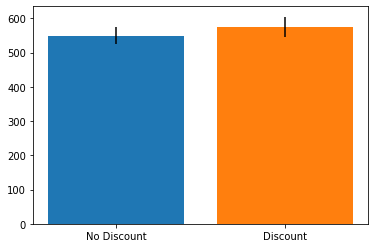

In [310]:
plt.bar(x = 'No Discount', height = no_discount_tp.mean(), 
        yerr = stats.sem(no_discount_tp))
plt.bar(x = 'Discount', height = discount_tp.mean(), 
        yerr = stats.sem(discount_tp))
plt.show();

And the same thing again with the pairwise tukey test

In [364]:
model = pairwise_tukeyhsd(dis_df.TotalPrice, dis_df.Discount)

In [365]:
print('Price level: All', ' | Discount: All')
print(model)

Price level: All  | Discount: All
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   0.0   0.05   114.028 0.5288  -77.6595 305.7155  False
   0.0    0.1  -45.4207    0.9 -260.0685 169.2271  False
   0.0   0.15   14.6068    0.9  -192.981 222.1946  False
   0.0    0.2  -78.6209 0.8947 -289.6362 132.3944  False
   0.0   0.25   98.4438  0.715 -105.9034 302.7909  False
  0.05    0.1 -159.4487 0.5392 -430.3594  111.462  False
  0.05   0.15  -99.4212 0.8913 -364.7731 165.9307  False
  0.05    0.2 -192.6489 0.3141 -460.6907  75.3929  False
  0.05   0.25  -15.5842    0.9 -278.4086 247.2402  False
   0.1   0.15   60.0275    0.9 -222.3573 342.4124  False
   0.1    0.2  -33.2002    0.9 -318.1141 251.7138  False
   0.1   0.25  143.8645 0.6623 -136.1466 423.8756  False
  0.15    0.2  -93.2277    0.9 -372.8614 186.4059  False
  0.15   0.25    83.837    0.9 -190.7996 358.4735  Fal

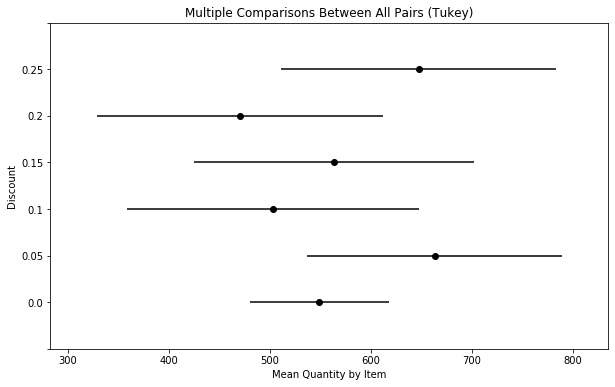

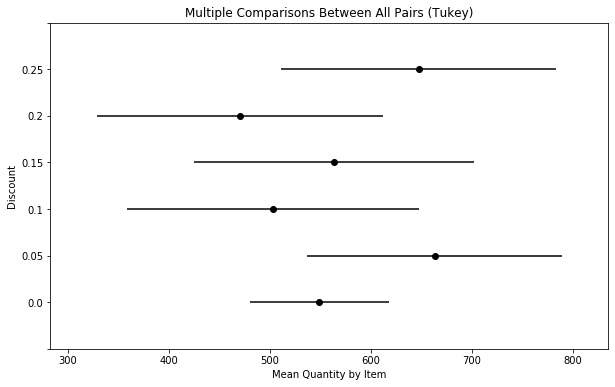

In [366]:
model.plot_simultaneous(ylabel = 'Discount', xlabel = 'Mean Quantity by Item')

**Result:**

**Failed to reject null hypothesis for every discount amount. Total price per order line item does not show statistically significant gain or loss with discounts applied against orders.**

The .05 discount is not far off, and a case could be made to attempt further study with larger sample sizes.

## Hypothesis 3

**Null Hypothesis:**

Customers who more frequently receive their product before required date do not order more product on average than those who don't.

**Alternative Hypothesis:**

Customers receiving product by their required date order more product on average than those who don't.

**Actionable Premise:**
    
If it can be shown with confidence that late shipments have a significantly detrimental effect on customer ordering habits, then additional resources might be allocated to ensure timely deliveries.

In [93]:
df_dates = poce.copy()
df_dates['PriceAfterDiscount'] = df_dates.UnitPrice - (
    df_dates.UnitPrice * df_dates.Discount)
df_dates['TotalPrice'] = df_dates.PriceAfterDiscount * df_dates.Quantity
df_hit_dates = df_dates[df_dates['ShippedDate'] <= df_dates['RequiredDate']]
df_miss_dates = df_dates[df_dates['ShippedDate'] > df_dates['RequiredDate']]

In [94]:
df_hit_group = df_hit_dates.groupby('CompanyName').size()

In [95]:
df_miss_group = df_miss_dates.groupby('CompanyName').size()

In [96]:
df_hit_v_miss = pd.concat([df_hit_group, df_miss_group], axis = 1, sort = True)

In [97]:
df_hit_v_miss.columns = ['Hit', 'Miss']

In [98]:
df_hit_v_miss['MissP'] = round(df_hit_v_miss['Miss'] / df_hit_v_miss['Hit'], 2)

In [99]:
df_hit_v_miss = df_hit_v_miss.fillna(0)

In [100]:
df_hit_v_miss['Miss'] = df_hit_v_miss['Miss'].astype(int)

In [101]:
kindly_treated_customers = df_hit_v_miss[df_hit_v_miss['MissP'] == 0]

In [102]:
mildly_misstreaded_customers = df_hit_v_miss[df_hit_v_miss['MissP'] > 0]

In [103]:
angry_customers = df_hit_v_miss[df_hit_v_miss['MissP'] >= .1]

In [104]:
order_vol_and_price = df_dates.groupby(['CompanyName']).sum()

In [105]:
customer_dissatisfaction = pd.concat([order_vol_and_price, angry_customers], 
                                     axis = 1, sort = True)

In [106]:
customer_dissatisfaction = customer_dissatisfaction.dropna()

In [107]:
customer_satisfaction = pd.concat([order_vol_and_price, 
                                   kindly_treated_customers], axis = 1, 
                                   sort = True)

In [108]:
customer_satisfaction = customer_satisfaction.dropna()

In [109]:
print('-----'*16)
print('control size: ', len(customer_satisfaction), ' | test size: ', 
      len(customer_dissatisfaction))
print('Control mean: ', customer_satisfaction.TotalPrice.mean(), 
      ' | Test mean: ', customer_dissatisfaction.TotalPrice.mean())
stats.ttest_ind(customer_dissatisfaction.TotalPrice, 
                customer_satisfaction.TotalPrice, equal_var = False)

--------------------------------------------------------------------------------
control size:  57  | test size:  21
Control mean:  11261.258517543862  | Test mean:  17075.468285714283


Ttest_indResult(statistic=1.010867726190998, pvalue=0.321221032440016)

It doesn't look good, but there is a problem: The samples are not equal. Customers receiving more late shipments are more likely to have more shipments to be late.
    

In [110]:
customer_dissatisfaction['TotalOrders'] = (customer_dissatisfaction.Hit + 
                                           customer_dissatisfaction.Miss)

In [111]:
customer_satisfaction['TotalOrders'] = (customer_satisfaction.Hit +
                                        customer_satisfaction.Miss)

In [112]:
customer_satisfaction.TotalOrders.mean()

20.24561403508772

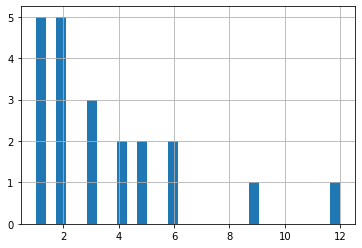

In [122]:
customer_dissatisfaction.Miss.hist(bins = 30)

In [114]:
customer_dissatisfaction.TotalOrders.mean()

25.666666666666668

So the mean number of orders per customer is five lower for customers with no late shipments.

So I will try to cull a new sample of control customers that will have a similar mean number of orders.

In [115]:
# Looping through customer_satisfaction numbers of orders placed,
# since that sample size is larger, until we have a similar sample in terms 
# of orders placed as the test sample, remembering that the ratio of hits to
# misses is what we are actually testing.
customer_happy_reduced = customer_satisfaction.copy()
alice = customer_happy_reduced.TotalOrders.sort_values(ascending = False)
cut = int(len(customer_happy_reduced)/3)
alice3 = alice[:cut]
alice2 = alice[cut:(cut*2)]
alice1 = alice[(cut*2):]

i = 0
while customer_happy_reduced['TotalOrders'].mean() < customer_dissatisfaction.TotalOrders.mean():
    if i >= 0:
        choice = random.choice(alice1.index)
        alice1.drop(choice, inplace = True)
        if choice in customer_happy_reduced.index:
            customer_happy_reduced.drop((choice), inplace = True, axis = 0)
    if i >= 1:
        choice = random.choice(alice2.index)
        alice2.drop(choice, inplace = True)
        if choice in customer_happy_reduced.index:
            customer_happy_reduced.drop((choice), inplace = True, axis = 0)
    if i == 2:
        choice = random.choice(alice3.index)
        alice3.drop(choice, inplace = True)
        if choice in customer_happy_reduced.index:
            customer_happy_reduced.drop((choice), inplace = True, axis = 0)
    if i == 2:
        i = 0
    else:
        i += 1

In [116]:
print('-----'*16)
print('control size: ', len(customer_happy_reduced), ' | test size: ', 
      len(customer_dissatisfaction))
print('Control mean: ', customer_happy_reduced.TotalPrice.mean(), 
    ' | Test mean: ', customer_dissatisfaction.TotalPrice.mean())
stats.ttest_ind(customer_dissatisfaction.TotalPrice, 
                customer_happy_reduced.TotalPrice, equal_var = False)

--------------------------------------------------------------------------------
control size:  30  | test size:  21
Control mean:  16292.729633333334  | Test mean:  17075.468285714283


Ttest_indResult(statistic=0.12023144153816413, pvalue=0.9049360173122669)

Much better! At least we were going the right direction this time with a mean higher volume for orders for customers without missed shipments. But not enough for a statistically significant result.

**The null hypotheses failed to be rejected.**

Although I was able to improve the sample sets by creating a more equal order mean, it was not enough to create enough of a difference in means to be significantly significant.

## Hypothesis 4

I'm just gonna serve myself up a softball with this one and pursue a null hypothesis that will most likely be rejected. However, I think it will have enough nuance to be interesting, worthwhile, and actionable.

**Null Hypothesis:**

There is no significant difference among sales people regarding the details of customer ordering habits.

**Alternative Hypothesis:**

There is no significant difference among sales people regarding the details of customer ordering habits.

*In terms of mean total dollars sold, total quantity sold, total orders sold, quantity per category sold, and ratio of categories sold.

**Actionable Premise:**

Though it may seem obvious on the surface that some employees sell more product than others, there might be more variables that tell a deeper story. For example, one employee might be sellng a large number of orders but for low-price products. Another might be selling fewer orders of high-end product and making more money for the company overall. Without looking at these factors, higher-producing employees (financially speaking) could potentially be under-rated by the company, and therefore undercompensated. 

In addition, by looking at categories, if some employees are selling fewer types of products on average than the larger group, it might be an opportunity to focus more on moving those underleveraged items.

In [840]:
emp_cats = odpcoe.copy()

In [841]:
emp_cats['YearMonth'] = emp_cats.OrderDate.apply(lambda x: datetime(
    x.year, x.month, 1))

In [842]:
emp_cats = pd.DataFrame(emp_cats)

In [843]:
mean_cats = pd.DataFrame(emp_cats)

In [844]:
emp_cats = emp_cats.groupby([emp_cats.FirstName, emp_cats.YearMonth,
                             emp_cats.CategoryName])['Quantity'].sum()

In [845]:
emp_cats = emp_cats.unstack(0).unstack(1)

In [846]:
type(emp_cats)

pandas.core.frame.DataFrame

In [847]:
mean_cats = round(mean_cats.groupby('YearMonth')['Quantity'].mean(),1)

In [848]:
mean_cats

YearMonth
2012-07-01    24.8
2012-08-01    19.2
2012-09-01    19.7
2012-10-01    23.8
2012-11-01    26.3
2012-12-01    27.2
2013-01-01    28.2
2013-02-01    27.0
2013-03-01    23.0
2013-04-01    23.6
2013-05-01    22.5
2013-06-01    21.5
2013-07-01    26.7
2013-08-01    22.2
2013-09-01    24.7
2013-10-01    25.3
2013-11-01    20.9
2013-12-01    23.5
2014-01-01    22.8
2014-02-01    25.5
2014-03-01    22.8
2014-04-01    26.0
2014-05-01    15.6
Name: Quantity, dtype: float64

In [849]:
emp_cats['MeanCats'] = mean_cats

In [850]:
emp_cats

FirstName       Andrew                                                       \
CategoryName Beverages Condiments Confections Dairy Products Grains/Cereals   
YearMonth                                                                     
2012-07-01        20.0        NaN         NaN            NaN            NaN   
2012-08-01        42.0        NaN        12.0            NaN            NaN   
2012-09-01        34.0       30.0        33.0            NaN            4.0   
2012-10-01        25.0       10.0        28.0           50.0            NaN   
2012-11-01         NaN       70.0        85.0            NaN           69.0   
2012-12-01        30.0       36.0         NaN           50.0           20.0   
2013-01-01         NaN        NaN        80.0          110.0           40.0   
2013-02-01         NaN        NaN         NaN           36.0            NaN   
2013-03-01         NaN        NaN        35.0            NaN           41.0   
2013-04-01        30.0        NaN       170.0          100.0           20.0   
2013-05-01        75.0       36.0        14.0           72.0           24.0   
2013-06-01         NaN       10.0         NaN           58.0           70.0   
2013-07-01        30.0      120.0         NaN           65.0          100.0   
2013-08-01         5.0        NaN         NaN            NaN            5.0   
2013-09-01         6.0       71.0        35.0           30.0           90.0   
2013-10-01        70.0       24.0        48.0            NaN            NaN   
2013-11-01        28.0       30.0         3.0           13.0           10.0   
2013-12-01        70.0       15.0         2.0           10.0           20.0   
2014-01-01       116.0       37.0        25.0           16.0           23.0   
2014-02-01       140.0        NaN         NaN           70.0            NaN   
2014-03-01        59.0       52.0       196.0           50.0           15.0   
2014-04-01       209.0      168.0        67.0          150.0           94.0   
2014-05-01        80.0        NaN        30.0           30.0            NaN   

FirstName                                      Anne                         \
CategoryName Meat/Poultry Produce Seafood Beverages Condiments Confections   
YearMonth                                                                    
2012-07-01           30.0     NaN     NaN      48.0        NaN        95.0   
2012-08-01           20.0    20.0     NaN       NaN        NaN         NaN   
2012-09-01           20.0     4.0    12.0       NaN        NaN         NaN   
2012-10-01           70.0     NaN    65.0      70.0       80.0        21.0   
2012-11-01            NaN    13.0     NaN       NaN        NaN         NaN   
2012-12-01          160.0     NaN    23.0      25.0        NaN         NaN   
2013-01-01            NaN     NaN     NaN       NaN       40.0         NaN   
2013-02-01            NaN     NaN     NaN       NaN        NaN         NaN   
2013-03-01           24.0    30.0    21.0      42.0       60.0         NaN   
2013-04-01           22.0     NaN   126.0      14.0        NaN        18.0   
2013-05-01            NaN     NaN     NaN       7.0        NaN         NaN   
2013-06-01           10.0    50.0    25.0      60.0       18.0         NaN   
2013-07-01            5.0     NaN    40.0       NaN        NaN         NaN   
2013-08-01            NaN     NaN     NaN      15.0       35.0         NaN   
2013-09-01           30.0    20.0   131.0      15.0        NaN         NaN   
2013-10-01           40.0     NaN     NaN       NaN        NaN         NaN   
2013-11-01           20.0     NaN    31.0      20.0       56.0         NaN   
2013-12-01           23.0    35.0     NaN      20.0        NaN         NaN   
2014-01-01            NaN    25.0    10.0      33.0       69.0        63.0   
2014-02-01           80.0     NaN     NaN      70.0       80.0        12.0   
2014-03-01           20.0    20.0   146.0      50.0       26.0       118.0   
2014-04-01          128.0    80.0   230.0      30.0       29.0        38.

In [853]:
emp_cats = emp_cats.fillna(0)

In [854]:
print(stats.ttest_ind(emp_cats['Andrew']['Beverages'], emp_cats['MeanCats']))

Ttest_indResult(statistic=2.100277237128897, pvalue=0.041470603484224246)


In [664]:
emp_cats = pd.DataFrame(emp_cats)

In [665]:
emp_cats = odpcoe.groupby([odpcoe.FirstName, odpcoe.CategoryName])[
    'Quantity'].sum().groupby('FirstName').apply(lambda x: x / x.sum())

In [666]:
# emp_cats = odpcoe.groupby([odpcoe.FirstName, odpcoe.CategoryName])[
#     'Quantity'].mean().groupby('FirstName').apply(lambda x: x / x.mean())

In [674]:
emp_cats = pd.DataFrame(emp_cats)

In [676]:
all_cats = odpcoe.groupby('CategoryName').Quantity.sum().apply(
    lambda x: x / odpcoe.Quantity.sum())

In [677]:
# all_cats = odpcoe.groupby('CategoryName').Quantity.mean().apply(
#     lambda x: x / odpcoe.Quantity.mean())

In [678]:
all_cats

CategoryName
Beverages         0.185747
Condiments        0.103241
Confections       0.154062
Dairy Products    0.178284
Grains/Cereals    0.088898
Meat/Poultry      0.081825
Produce           0.058265
Seafood           0.149677
Name: Quantity, dtype: float64

In [679]:
all_cats = pd.DataFrame(all_cats)

In [680]:
all_cats

,Quantity
CategoryName,
Beverages,0.185747
Condiments,0.103241
Confections,0.154062
Dairy Products,0.178284
Grains/Cereals,0.088898
Meat/Poultry,0.081825
Produce,0.058265
Seafood,0.149677


In [681]:
all_cats = all_cats.rename({'Quantity': 'EmpRatio'}, axis = 1)
emp_cats = emp_cats.rename({'Quantity': 'EmpRatio'}, axis = 1)

In [682]:
temp = pd.Series()

In [683]:
for index, row in emp_cats.iterrows():
    for cat_index, cat in all_cats.iterrows():
        if index[1] == cat_index:
            temp = temp.append(pd.Series(cat))

In [684]:
emp_cats['AllRatio'] = temp.values

In [685]:
emp_cats['PctDelta'] = (emp_cats.EmpRatio - emp_cats.AllRatio) / emp_cats.EmpRatio

In [686]:
emp_cats = round(emp_cats[['EmpRatio', 'AllRatio', 'PctDelta']], 2)

In [690]:
emp_cats

EmpRatio  AllRatio  PctDelta
FirstName CategoryName                                
Andrew    Beverages           0.18      0.19     -0.05
          Condiments          0.12      0.10      0.12
          Confections         0.14      0.15     -0.08
          Dairy Products      0.15      0.18     -0.19
          Grains/Cereals      0.11      0.09      0.17
          Meat/Poultry        0.12      0.08      0.29
          Produce             0.05      0.06     -0.19
          Seafood             0.14      0.15     -0.05
Anne      Beverages           0.19      0.19      0.04
          Condiments          0.18      0.10      0.44
          Confections         0.14      0.15     -0.13
          Dairy Products      0.24      0.18      0.26
          Grains/Cereals      0.03      0.09     -2.21
          Meat/Poultry        0.05      0.08     -0.62
          Produce             0.02      0.06     -2.79
          Seafood             0.15      0.15      0.01
Janet     Beverages           0.17      0.19     -0.11
          Condiments          0.09      0.10     -0.21
          Confections         0.17      0.15      0.10
          Dairy Products      0.17      0.18     -0.07
          Grains/Cereals      0.11      0.09      0.21
          Meat/Poultry        0.07      0.08     -0.22
          Produce             0.04      0.06     -0.40
          Seafood             0.19      0.15      0.21
Laura     Beverages           0.22      0.19      0.16
          Condiments          0.11      0.10      0.04
          Confections         0.17      0.15      0.08
          Dairy Products      0.12      0.18     -0.45
          Grains/Cereals      0.12      0.09      0.24
          Meat/Poultry        0.07      0.08     -0.15
          Produce             0.07      0.06      0.16
          Seafood             0.12      0.15     -0.20
Margaret  Beverages           0.16      0.19     -0.16
          Condiments          0.13      0.10      0.19
          Confections         0.16      0.15      0.02
          Dairy Products      0.15      0.18     -0.20
          Grains/Cereals      0.10      0.09      0.13
          Meat/Poultry        0.09      0.08      0.13
          Produce             0.06      0.06     -0.02
          Seafood             0.15      0.15      0.03
Michael   Beverages           0.22      0.19      0.16
          Condiments          0.07      0.10     -0.43
          Confections         0.11      0.15     -0.38
          Dairy Products      0.21      0.18      0.14
          Grains/Cereals      0.09      0.09     -0.00
          Meat/Poultry        0.05      0.08     -0.60
          Produce             0.11      0.06      0.45
          Seafood             0.14      0.15     -0.04
Nancy     Beverages           0.21      0.19      0.10
          Condiments          0.08      0.10     -0.24
          Confections         0.17      0.15      0.10
          Dairy Products      0.20      0.18      0.09
          Grains/Cereals      0.05      0.09     -0.65
          Meat/Poultry        0.07      0.08     -0.18
          Produce             0.06      0.06      0.07
          Seafood             0.16      0.15      0.06
Robert    Beverages           0.20      0.19      0.09
          Condiments          0.10      0.10      0.01
          Confections         0.16      0.15      0.03
          Dairy Products      0.20      0.18      0.12
          Grains/Cereals      0.07      0.09     -0.29
          Meat/Poultry        0.08      0.08      0.04
          Produce             0.06      0.06     -0.01
          Seafood             0.12      0.15     -0.26
Steven    Beverages           0.14      0.19     -0.34
          Condiments          0.05      0.10     -1.10
          Confections         0.11      0.15     -0.38
          Dairy Products      0.30      0.18      0.41
          Grains/Cereals      0.07      0.09     -0.27
          Meat/Poultry        0.12      0.08      0.34
          Produce             0.07      0.06      0.21
          S

In [688]:
print(stats.ttest_ind(emp_cats.EmpRatio, emp_cats.AllRatio))

Ttest_indResult(statistic=0.0, pvalue=1.0)


In [689]:
model = pairwise_tukeyhsd(emp_cats.EmpRatio, emp_cats.AllRatio)
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.06,0.08,0.02,0.8234,-0.0262,0.0662,False
0.06,0.09,0.0233,0.6977,-0.0229,0.0696,False
0.06,0.1,0.0433,0.0809,-0.0029,0.0896,False
0.06,0.15,0.0861,0.001,0.0461,0.1262,True
0.06,0.18,0.1333,0.001,0.0871,0.1796,True
0.06,0.19,0.1278,0.001,0.0815,0.174,True
0.08,0.09,0.0033,0.9,-0.0429,0.0496,False
0.08,0.1,0.0233,0.6977,-0.0229,0.0696,False
0.08,0.15,0.0661,0.001,0.0261,0.1062,True
0.08,0.18,0.1133,0.001,0.0671,0.1596,True
